In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16

2024-08-28 09:48:10.358348: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 09:48:10.424052: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 09:48:10.425167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 09:48:11.856324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
vgg = VGG16(
  input_shape=[100, 100, 3],
  include_top=False, 
  weights='imagenet'
)

2024-08-28 09:48:13.889672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 09:48:13.968626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
x = Flatten()(vgg.output)
x = Dense(4, activation='sigmoid')(x)
model = Model(vgg.input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [42]:
def image_generator(batch_size=64):

  while True:
    # Batch x Height x Width x Channels
    X = np.zeros((batch_size, 100, 100, 3))
    Y = np.zeros((batch_size, 4))
    for i in range(batch_size):
      y_min = np.random.randint(0, 90)
      x_min = np.random.randint(0, 90)
      y_max = np.random.randint(y_min, 100)
      x_max = np.random.randint(x_min, 100)

      X[i, y_min:y_max, x_min:x_max] = 1    
      Y[i, 0] = y_min / 100
      Y[i, 1] = x_min / 100
      Y[i, 2] = (y_max - y_min) / 100
      Y[i, 3] = (x_max - x_min) / 100

    yield X, Y


In [11]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.0001)
)
model.fit(
  image_generator(),
  steps_per_epoch=50,
  epochs=5
)
model.save('white-patches-localizer.h5')


Epoch 1/5
50/50 [==============================] - 484s 10s/step - loss: 0.5603
Epoch 2/5
50/50 [==============================] - 491s 10s/step - loss: 0.4974
Epoch 3/5
50/50 [==============================] - 505s 10s/step - loss: 0.4874
Epoch 4/5
50/50 [==============================] - 480s 10s/step - loss: 0.4819
Epoch 5/5
50/50 [==============================] - 437s 9s/step - loss: 0.4837


In [12]:
from keras.models import load_model
model = load_model('white-patches-localizer.h5')

/home/jakubner/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 54ms/step
[22.639862 51.701134 63.26378  22.94185 ]


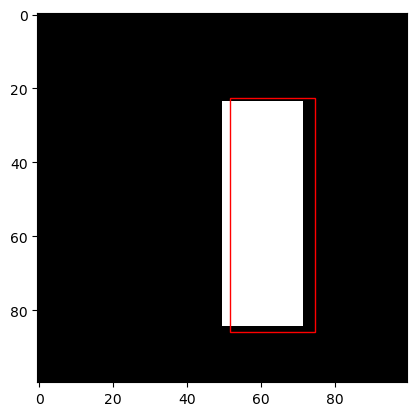

1/1 [==============================] - 0s 57ms/step
[72.057175 87.28922  22.948637  6.713584]


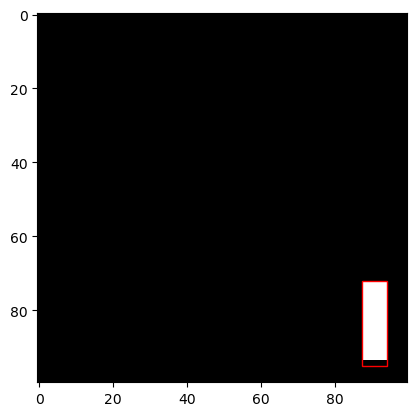

1/1 [==============================] - 0s 55ms/step
[64.15353  55.93692  36.437122 25.134205]


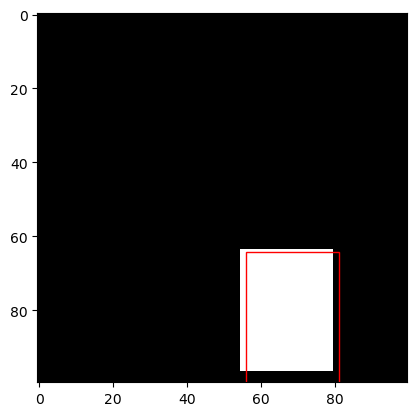

1/1 [==============================] - 0s 52ms/step
[66.73169  60.032684 14.695968 17.729256]


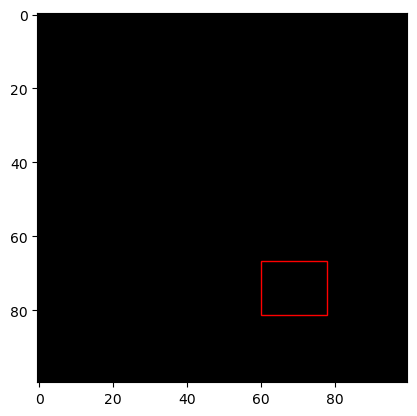

1/1 [==============================] - 0s 60ms/step
[13.139627 18.362707 74.77936  40.79791 ]


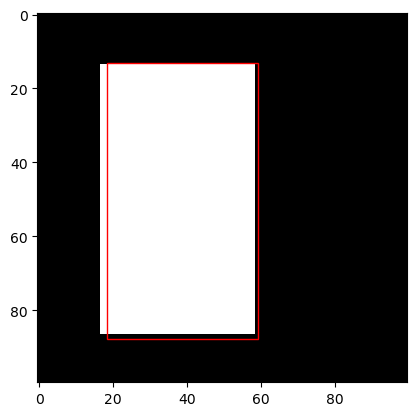

In [43]:
from matplotlib.patches import Rectangle

def make_prediction():
  X, _ = image_generator(1).__next__()
  result = model.predict(X)[0] * 100
  print(result)

  fig, ax = plt.subplots(1)
  ax.imshow(X[0], cmap='gray')
  rect = Rectangle(
    (result[1], result[0]),
    result[3], result[2],
    linewidth=1, edgecolor='r', facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()

make_prediction()
make_prediction()
make_prediction()
make_prediction()
make_prediction()